In [2]:
# This is to setup the various paths used in the entire notebook
from os.path import join
import os

ROOT = '/home/ashar'     # default for the drive
CODE = 'LaneNet'       # path to our code on Drive
DATASET = 'dataset/trainset'
EXPERIMENT = 'LaneNet/config'
MODEL_SAVE = 'pretrained'
PRETRAINED = 'pretrained'

CODE_PATH = join(ROOT, CODE)
DATASET_PATH = join(ROOT, DATASET)
EXPERIMENT_CONFIG = join(ROOT, EXPERIMENT)
MODEL_SAVE = join(ROOT, MODEL_SAVE)
PRETRAINED_PATH = join(ROOT, PRETRAINED)

# This ensures that the Python interpreter can load
# python files from within it.
import sys
sys.path.append('{}'.format(CODE_PATH))

## Dataset Image Generation


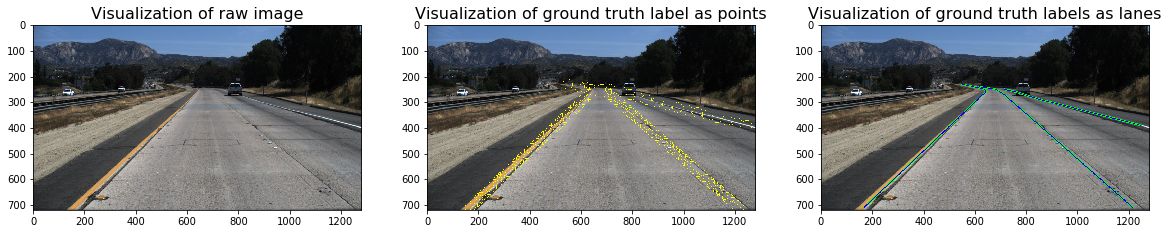

In [3]:
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import rcParams

json_path = join(DATASET_PATH, 'label_data_0531.json')

json_pred = [json.loads(line) for line in open(json_path).readlines()]
json_gt = [json.loads(line) for line in open(json_path)]

pred, gt = json_pred[2], json_gt[2]
pred_lanes = pred['lanes']
#run_time = pred['run_time']
gt_lanes = gt['lanes']
y_samples = gt['h_samples']
raw_file = gt['raw_file']

# Let's checkout the image
img = plt.imread('./../../dataset/trainset/'+raw_file)

# Let's checkout the lanes
gt_lanes_vis = [[(x, y) for (x, y) in zip(lane, y_samples) if x >= 0] for lane in gt_lanes]
img_vis = img.copy()

for lane in gt_lanes_vis:
    for pt in lane:
        cv2.circle(img_vis, pt, radius=20, color=(255, 255, 0))

img2 = img_vis.copy()

gt_lanes_vis = [[(x, y) for (x, y) in zip(lane, y_samples) if x >= 0] for lane in gt_lanes]
pred_lanes_vis = [[(x, y) for (x, y) in zip(lane, y_samples) if x >= 0] for lane in pred_lanes]
img_vis = img.copy()

for lane in gt_lanes_vis:
    cv2.polylines(img_vis, np.int32([lane]), isClosed=False, color=(0,255,0), thickness=5)
for lane in pred_lanes_vis:
    cv2.polylines(img_vis, np.int32([lane]), isClosed=False, color=(0,0,255), thickness=2)


# figure size in inches optional
rcParams['figure.figsize'] = 20 ,15

# Plotting images
fig, ax = plt.subplots(1,3);
ax[0].imshow(img);
ax[0].set_title('Visualization of raw image', fontsize=16);
ax[1].imshow(img2);
ax[1].set_title('Visualization of ground truth label as points', fontsize=16);
ax[2].imshow(img_vis);
ax[2].set_title('Visualization of ground truth labels as lanes', fontsize=16);


/home/ashar/LaneNet/notebooks


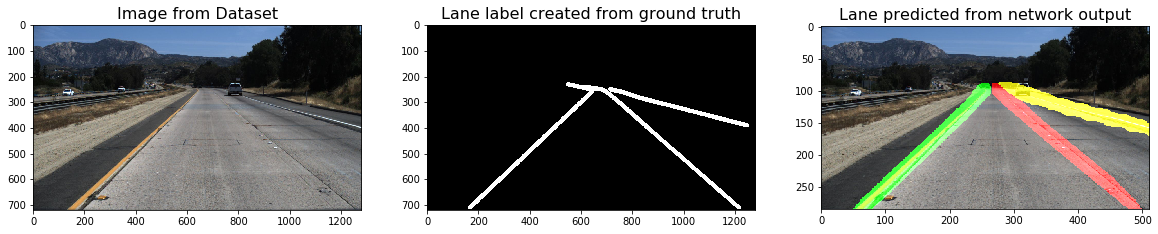

In [4]:
!pwd
gt = json_gt[2]
raw_image = gt['raw_file']
# Let's checkout the image
img = plt.imread('./../../dataset/trainset/'+raw_file)
img3 = plt.imread('./../../labelled.png')
img4 = plt.imread('./../../labelled_lane.png')

# ---------- clean and sort lanes -------------
label = gt
lanes = []
_lanes = []
slope = [] # identify 1st, 2nd, 3rd, 4th lane through slope
for i in range(len(label['lanes'])):
    l = [(x, y) for x, y in zip(label['lanes'][i], label['h_samples']) if x >= 0]
    if (len(l)>1):
        _lanes.append(l)
        slope.append(np.arctan2(l[-1][1]-l[0][1], l[0][0]-l[-1][0]) / np.pi * 180)
_lanes = [_lanes[i] for i in np.argsort(slope)]
slope = [slope[i] for i in np.argsort(slope)]

idx_1 = None
idx_2 = None
idx_3 = None
idx_4 = None
for i in range(len(slope)):
    if slope[i]<=90:
        idx_2 = i
        idx_1 = i-1 if i>0 else None
    else:
        idx_3 = i
        idx_4 = i+1 if i+1 < len(slope) else None
        break
lanes.append([] if idx_1 is None else _lanes[idx_1])
lanes.append([] if idx_2 is None else _lanes[idx_2])
lanes.append([] if idx_3 is None else _lanes[idx_3])
lanes.append([] if idx_4 is None else _lanes[idx_4])
# ---------------------------------------------

H, W = 720, 1280
SEG_WIDTH = 30
seg_img = np.zeros((H, W, 3))
list_str = []  # str to be written to list.txt
for i in range(4):
  coords = lanes[i]
  if len(coords) < 4:
      continue
  for j in range(len(coords)-1):
      ################ THE ISSUE WAS THE COLOR HERE
      cv2.line(seg_img, coords[j], coords[j+1], (255, 255, 255), SEG_WIDTH//2)
      ################ THE ISSUE WAS THE COLOR HERE
  list_str.append('1')
 
cv2.imwrite('img.png', seg_img)
img2 = plt.imread('img.png')

# figure size in inches optional
rcParams['figure.figsize'] = 20 ,15

# Plotting images
fig, ax = plt.subplots(1,3);
ax[0].imshow(img)
ax[0].set_title('Image from Dataset', fontsize=16);
ax[1].imshow(img2);
ax[1].set_title('Lane label created from ground truth', fontsize=16);
ax[2].imshow(img3);
ax[2].set_title('Lane predicted from network output', fontsize=16);

# Visualizing results

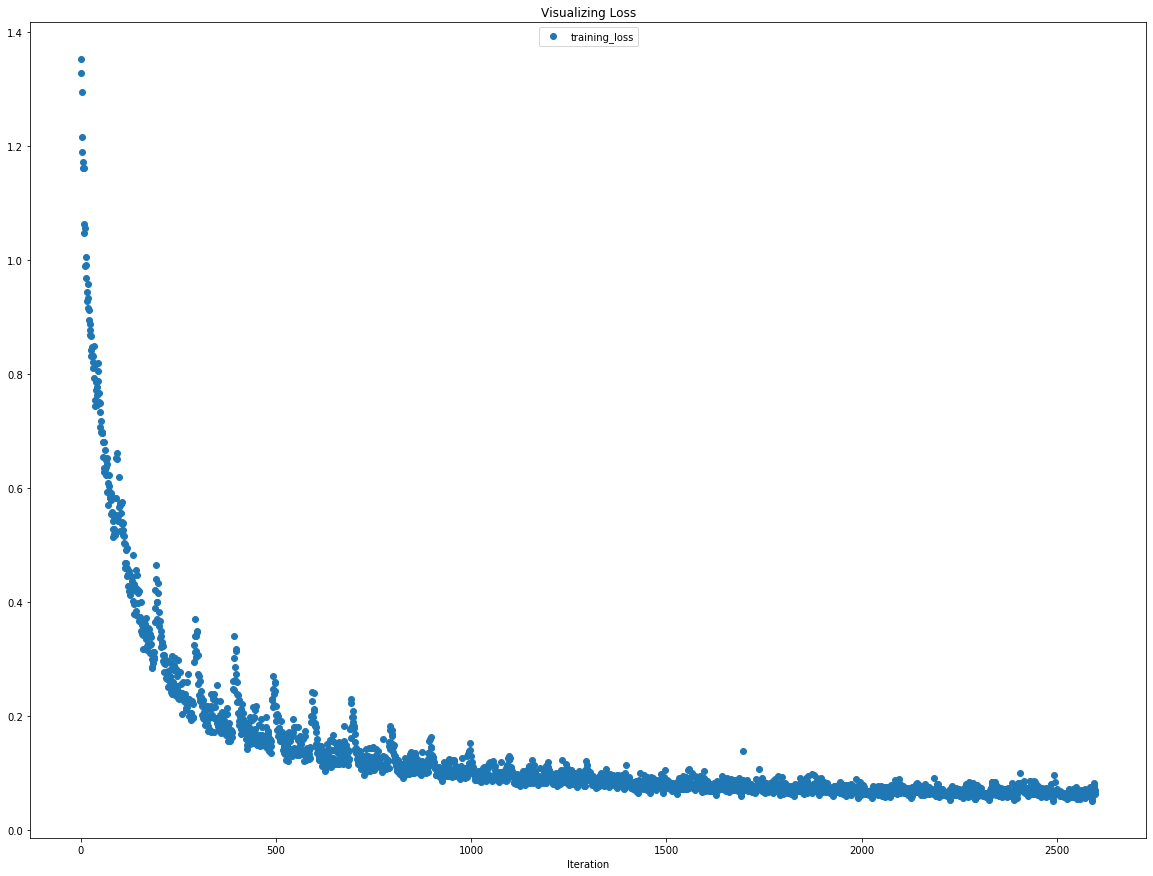

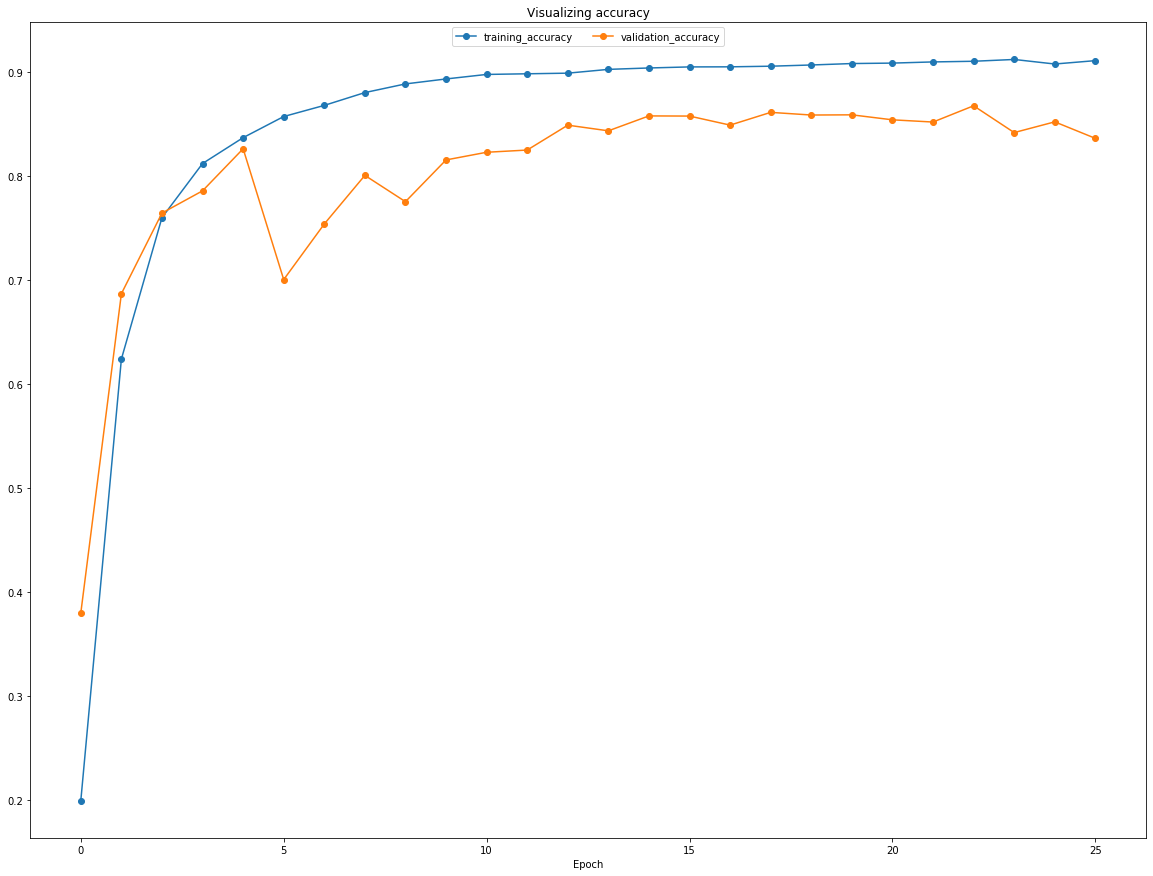

In [5]:
import pickle as pickle

exp_name = 'june_4_batch_32_googlenet'
save_dir = MODEL_SAVE + '/' + exp_name
## Plotting our pickle                                                                                                                                                          # Visualizing the loss
save_name = os.path.join(save_dir, exp_name + '.pkl')
with open(save_name, "rb") as f:
  checkpoint = pickle.load(f)
f.close() # Closing the file to prevent mess from spreading

# ------------------------------>We can still add some plots after doing 10 epochs -> feature request
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

plt.title('Visualizing Loss')
plt.plot(checkpoint["train_loss_total"], 'o', label="training_loss")
plt.xlabel('Iteration')
plt.legend(loc='upper center', ncol=4)
plt.show()

plt.title('Visualizing accuracy')
plt.plot(checkpoint["train_accuracy"], 'o', label="training_accuracy", linestyle="-")
plt.plot(checkpoint["val_accuracy"], 'o', label="validation_accuracy", linestyle="-")
plt.xlabel('Epoch')
plt.legend(loc='upper center', ncol=4)
plt.show()

<class 'list'>
365


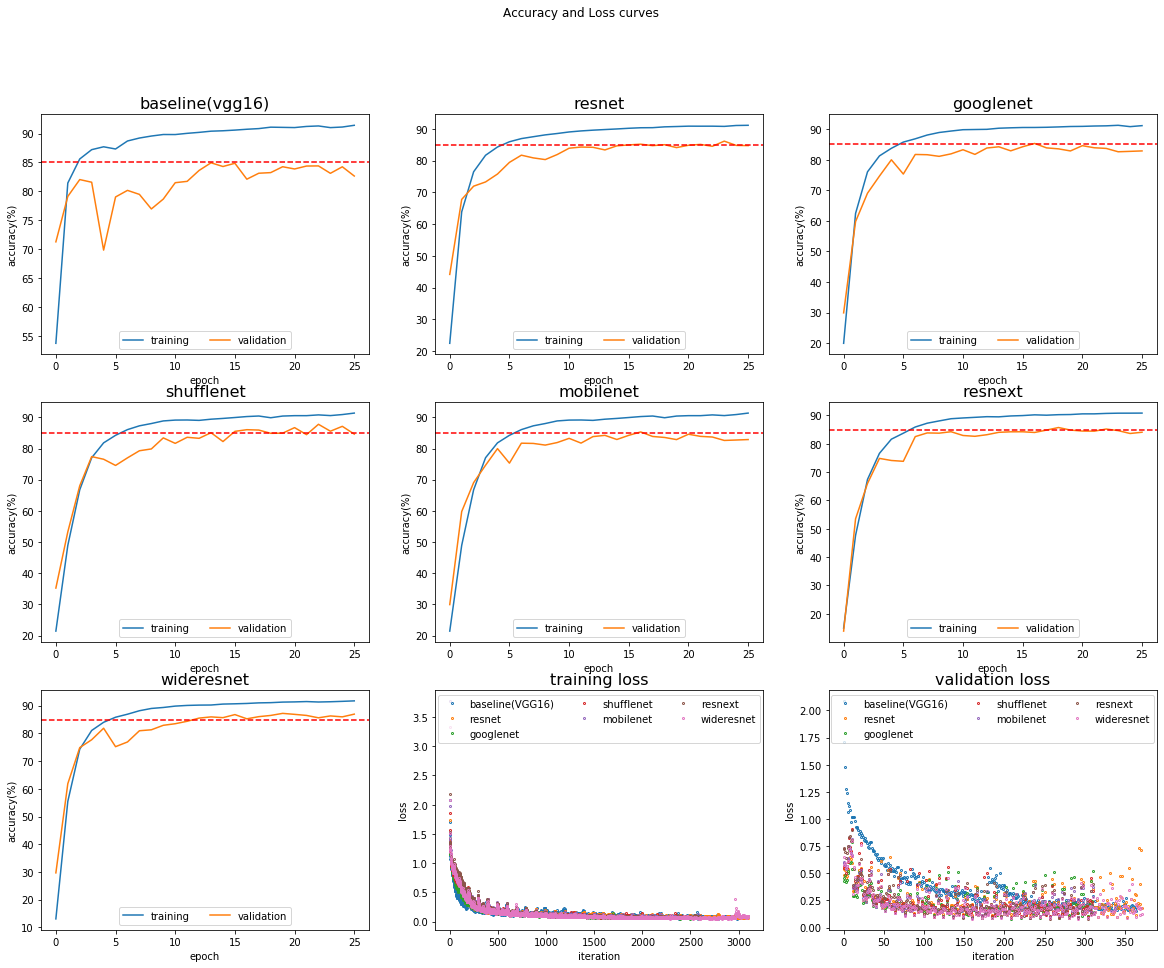

In [89]:
import pickle as pickle
import pandas as pd

baseline = 'june_4_batch_32_baseline'
resnet = 'june_4_batch_32_2'
googlenet = 'june_4_batch_32_googlenet'
shufflenet = 'june_4_batch_32_shufflenet'
mobilenet = 'june_4_batch_32_mobilenet'
resnext = 'june_4_batch_32_resnext'
wideresnet = 'june_4_batch_32_wideresnet'

save_dir_baseline = MODEL_SAVE + '/' + baseline
save_dir_resnet = MODEL_SAVE + '/' + resnet
save_dir_googlenet = MODEL_SAVE + '/' + googlenet
save_dir_shufflenet = MODEL_SAVE + '/' + shufflenet
save_dir_mobilenet = MODEL_SAVE + '/' + mobilenet
save_dir_resnext = MODEL_SAVE + '/' + resnext
save_dir_wideresnet = MODEL_SAVE + '/' + wideresnet

## Plotting our pickle                                                                                                                                                          # Visualizing the loss
save_name_baseline = os.path.join(save_dir_baseline, baseline + '.pkl')
save_name_resnet = os.path.join(save_dir_resnet, resnet + '.pkl')
save_name_googlenet = os.path.join(save_dir_googlenet, googlenet + '.pkl')
save_name_shufflenet = os.path.join(save_dir_shufflenet, shufflenet + '.pkl')
save_name_mobilenet = os.path.join(save_dir_mobilenet, mobilenet + '.pkl')
save_name_resnext = os.path.join(save_dir_resnext, resnext + '.pkl')
save_name_wideresnet = os.path.join(save_dir_wideresnet, wideresnet + '.pkl')


with open(save_name_baseline, "rb") as f:
  checkpoint_baseline = pickle.load(f)
  print(type(checkpoint_baseline["train_accuracy"]))
  checkpoint_baseline["train_accuracy"] = pd.Series(checkpoint_baseline["train_accuracy"])*100
  checkpoint_baseline["val_accuracy"] = pd.Series(checkpoint_baseline["val_accuracy"])*100
  checkpoint_baseline["train_loss_total"] = checkpoint_baseline["train_loss_total"][:3000]
  checkpoint_baseline["val_loss_total"] = checkpoint_baseline["train_loss_total"][:365]
f.close() # Closing the file to prevent mess from spreading

with open(save_name_resnet, "rb") as f:
  checkpoint_resnet = pickle.load(f)
  checkpoint_resnet["train_accuracy"] = pd.Series(checkpoint_resnet["train_accuracy"][:26])*100
  checkpoint_resnet["val_accuracy"] = pd.Series(checkpoint_resnet["val_accuracy"][:26])*100
f.close() # Closing the file to prevent mess from spreading

with open(save_name_googlenet, "rb") as f:
  checkpoint_googlenet = pickle.load(f)
  checkpoint_googlenet["train_accuracy"] = pd.Series(checkpoint_googlenet["train_accuracy"])*100
  checkpoint_googlenet["val_accuracy"] = pd.Series(checkpoint_googlenet["val_accuracy"])*100
f.close() # Closing the file to prevent mess from spreading

with open(save_name_shufflenet, "rb") as f:
  checkpoint_shufflenet = pickle.load(f)
  checkpoint_shufflenet["train_accuracy"] = pd.Series(checkpoint_shufflenet["train_accuracy"])*100
  checkpoint_shufflenet["val_accuracy"] = pd.Series(checkpoint_shufflenet["val_accuracy"])*100
f.close() # Closing the file to prevent mess from spreading

with open(save_name_mobilenet, "rb") as f:
  checkpoint_mobilenet = pickle.load(f)
  checkpoint_mobilenet["train_accuracy"] = pd.Series(checkpoint_mobilenet["train_accuracy"])*100
  checkpoint_mobilenet["val_accuracy"] = pd.Series(checkpoint_mobilenet["val_accuracy"])*100
f.close() # Closing the file to prevent mess from spreading

with open(save_name_resnext, "rb") as f:
  checkpoint_resnext = pickle.load(f)
  checkpoint_resnext["train_accuracy"] = pd.Series(checkpoint_resnext["train_accuracy"])*100
  checkpoint_resnext["val_accuracy"] = pd.Series(checkpoint_resnext["val_accuracy"])*100
f.close() # Closing the file to prevent mess from spreading

with open(save_name_wideresnet, "rb") as f:
  checkpoint_wideresnet = pickle.load(f)
  checkpoint_wideresnet["train_accuracy"] = pd.Series(checkpoint_wideresnet["train_accuracy"][:26])*100
  checkpoint_wideresnet["val_accuracy"] = pd.Series(checkpoint_wideresnet["val_accuracy"][:26])*100
f.close() # Closing the file to prevent mess from spreading

# Plotting accuracies
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3)
fig.suptitle('Accuracy and Loss curves')
# Training

ax1.plot(checkpoint_baseline["train_accuracy"], label="training", linestyle="-")
ax1.plot(checkpoint_baseline["val_accuracy"], label="validation")
ax1.set_title('baseline(vgg16)', fontsize=16)
ax1.set(xlabel='epoch', ylabel='accuracy(%)')
ax2.plot(checkpoint_resnet["train_accuracy"], label="training", linestyle="-")
ax2.plot(checkpoint_resnet["val_accuracy"], label="validation")
ax2.set_title('resnet', fontsize=16)
ax2.set(xlabel='epoch', ylabel='accuracy(%)')
ax4.plot(checkpoint_shufflenet["train_accuracy"], label="training")
ax4.plot(checkpoint_shufflenet["val_accuracy"], label="validation")
ax4.set_title('shufflenet', fontsize=16)
ax4.set(xlabel='epoch', ylabel='accuracy(%)')
ax3.plot(checkpoint_googlenet["train_accuracy"], label="training", linestyle="-")
ax3.plot(checkpoint_mobilenet["val_accuracy"], label="validation")
ax3.set_title('googlenet', fontsize=16)
ax3.set(xlabel='epoch', ylabel='accuracy(%)')
ax5.plot(checkpoint_shufflenet["train_accuracy"], label="training", linestyle="-")
ax5.plot(checkpoint_mobilenet["val_accuracy"], label="validation")
ax5.set_title('mobilenet', fontsize=16)
ax5.set(xlabel='epoch', ylabel='accuracy(%)')
ax6.plot(checkpoint_mobilenet["train_accuracy"],  label="training", linestyle="-")
ax6.plot(checkpoint_resnext["val_accuracy"],  label="validation", linestyle="-")
ax6.set_title('resnext', fontsize=16)
ax6.set(xlabel='epoch', ylabel='accuracy(%)')
ax7.plot(checkpoint_wideresnet["train_accuracy"], label="training", linestyle="-")
ax7.plot(checkpoint_wideresnet["val_accuracy"], label="validation")
ax7.set_title('wideresnet', fontsize=16)
ax7.set(xlabel='epoch', ylabel='accuracy(%)')

ax1.legend(loc='lower center', ncol=2)
ax2.legend(loc='lower center', ncol=2)
ax3.legend(loc='lower center', ncol=2)
ax4.legend(loc='lower center', ncol=2)
ax5.legend(loc='lower center', ncol=2)
ax6.legend(loc='lower center', ncol=2)
ax7.legend(loc='lower center', ncol=2)

ax1.axhline(y=85, color='r', linestyle='--')
ax2.axhline(y=85, color='r', linestyle='--')
ax3.axhline(y=85, color='r', linestyle='--')
ax4.axhline(y=85, color='r', linestyle='--')
ax5.axhline(y=85, color='r', linestyle='--')
ax6.axhline(y=85, color='r', linestyle='--')
ax7.axhline(y=85, color='r', linestyle='--')

"""
ax2.plot(checkpoint_baseline["val_accuracy"], label="baseline(VGG16)")
ax2.plot(checkpoint_googlenet["val_accuracy"], label="googlenet")
ax2.plot(checkpoint_shufflenet["val_accuracy"], label="shufflenet")
ax2.plot(checkpoint_mobilenet["val_accuracy"], label="mobilenet")
ax2.plot(checkpoint_resnext["val_accuracy"], label="resnext")
ax2.plot(checkpoint_wideresnet["val_accuracy"], label="wideresnet")
ax2.legend(loc='lower center', ncol=7)
"""
ax8.plot(checkpoint_baseline["train_loss_total"], 'o', label="baseline(VGG16)", ms=2, mfc ="none")
ax8.plot(checkpoint_resnet["train_loss_total"], 'o',label="resnet", ms=2, mfc ="none")
ax8.plot(checkpoint_googlenet["train_loss_total"], 'o',label="googlenet", ms=2, mfc ="none")
ax8.plot(checkpoint_shufflenet["train_loss_total"], 'o',label="shufflenet", ms=2, mfc ="none")
ax8.plot(checkpoint_mobilenet["train_loss_total"],  'o',label="mobilenet", ms=2, mfc ="none")
ax8.plot(checkpoint_resnext["train_loss_total"],  'o',label="resnext", ms=2, mfc ="none")
ax8.plot(checkpoint_wideresnet["train_loss_total"], 'o', label="wideresnet", ms=2, mfc ="none")
ax8.legend(loc='upper center', ncol=3)
ax8.set_title('training loss', fontsize=16)
ax8.set(xlabel='iteration', ylabel='loss')



ax9.plot(checkpoint_baseline["val_loss_total"], 'o', label="baseline(VGG16)", ms=2, mfc ="none")
ax9.plot(checkpoint_resnet["val_loss_total"], 'o',label="resnet", ms=2, mfc ="none")
ax9.plot(checkpoint_googlenet["val_loss_total"], 'o',label="googlenet", ms=2, mfc ="none")
ax9.plot(checkpoint_shufflenet["val_loss_total"], 'o',label="shufflenet", ms=2, mfc ="none")
ax9.plot(checkpoint_mobilenet["val_loss_total"], 'o',label="mobilenet", ms=2, mfc ="none")
ax9.plot(checkpoint_resnext["val_loss_total"], 'o',label="resnext", ms=2, mfc ="none")
ax9.plot(checkpoint_wideresnet["val_loss_total"], 'o',label="wideresnet", ms=2, mfc ="none")
ax9.legend(loc='upper center', ncol=3)
ax9.set_title('validation loss', fontsize=16)
ax9.set(xlabel='iteration', ylabel='loss')

print(len(checkpoint_baseline["val_loss_total"]))


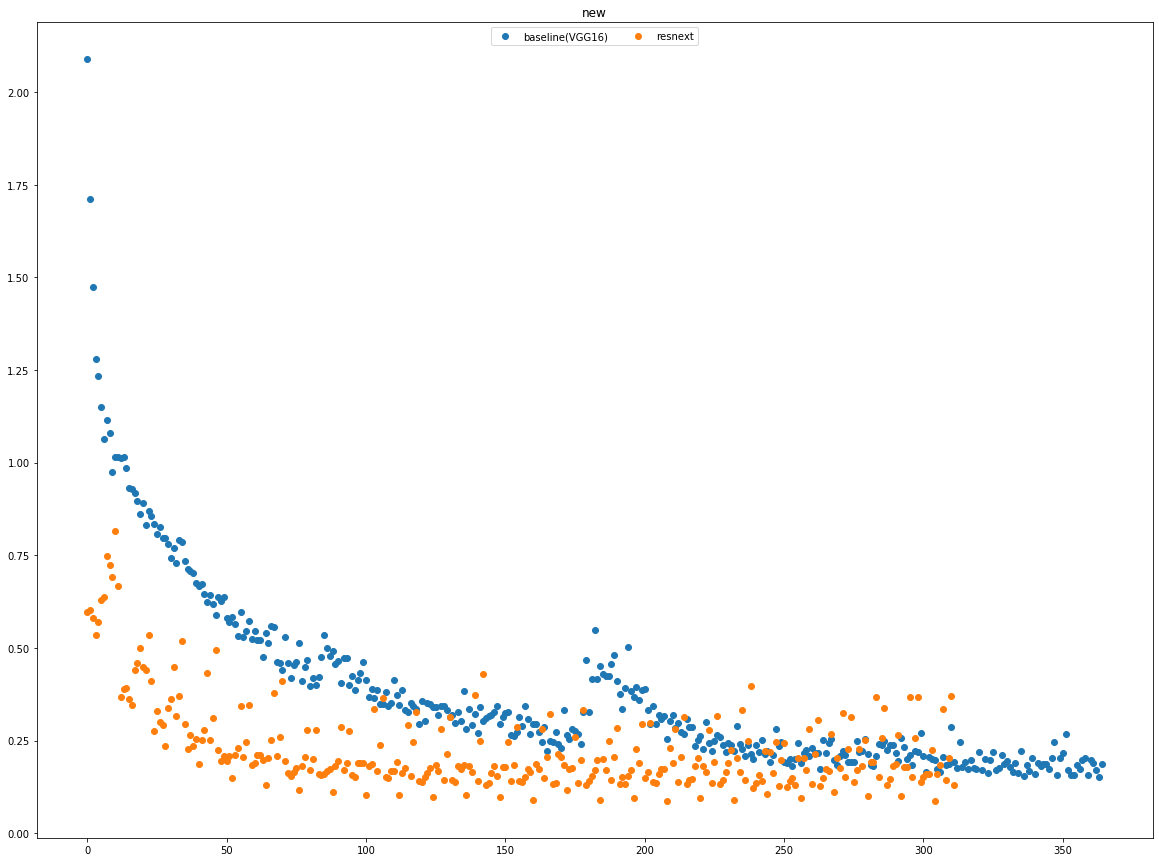

In [86]:
plt.title("new")
plt.plot(checkpoint_baseline["val_loss_total"], 'o', label="baseline(VGG16)")
plt.plot(checkpoint_mobilenet["val_loss_total"],  'o', label="resnext")
plt.legend(loc='upper center', ncol=7)
plt.show()

In [16]:
#Test set accuracy
def f_measure(fp, fn):
    tp = 1-fp
    tn = 1-fn
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    return 2*(precision*recall)/(precision+recall)


baseline = 86.52
baseline_fp = 0.2521
baseline_fn = 0.2682

resnet = 85.67
resnet_fp = 0.3092
resnet_fn = 0.2680

googlenet = 84.49
googlenet_fp = 0.2402
googlenet_fn = 0.2711

shufflenet = 86.75
shufflenet_fp = 0.2502
shufflenet_fn = 0.2684

mobilenet = 85.20
mobilenet_fp = 0.2558
mobilenet_fn = 0.2806

resnext = 86.92
resnext_fp = 0.2079
resnext_fn = 0.2298

wideresnet = 86.39
wideresnet_fp = 0.2411
wideresnet_fn = 0.2650

print(f_measure(baseline_fp,baseline_fn))
print(f_measure(resnet_fp,resnet_fn))
print(f_measure(googlenet_fp,googlenet_fn))
print(f_measure(shufflenet_fp,shufflenet_fn))
print(f_measure(mobilenet_fp,mobilenet_fn))
print(f_measure(resnext_fp,resnext_fn))
print(f_measure(wideresnet_fp,wideresnet_fn))

0.741927483755766
0.7053297937512764
0.7482396966861984
0.7430383510058468
0.7350849466613986
0.7835204510608834
0.74993823805524


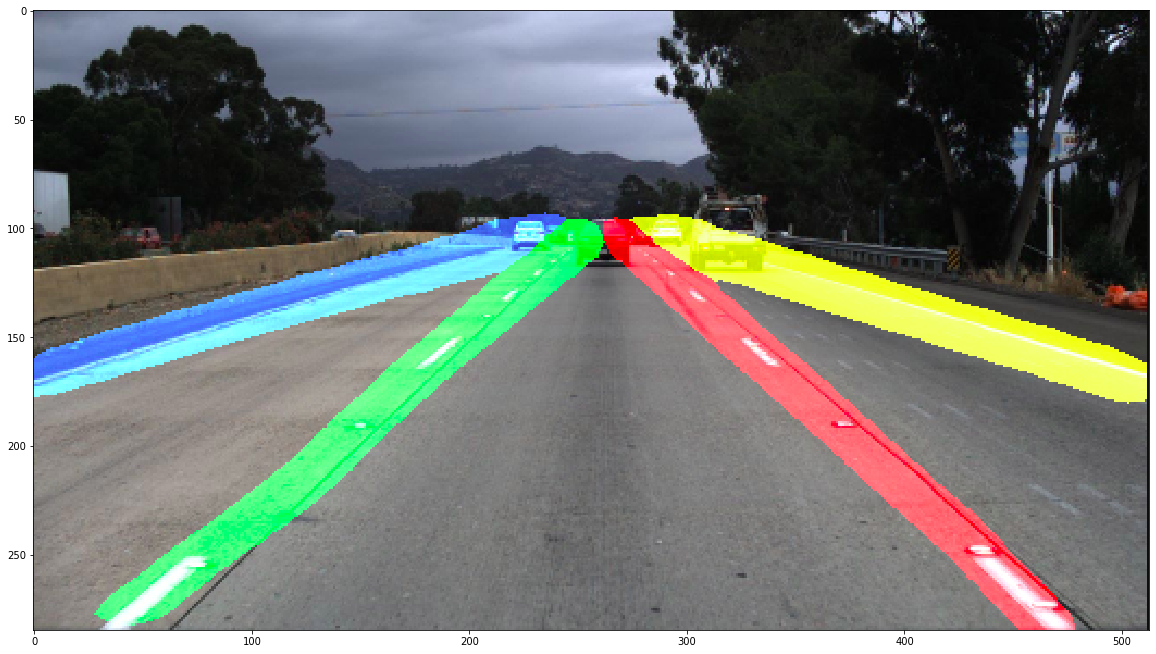

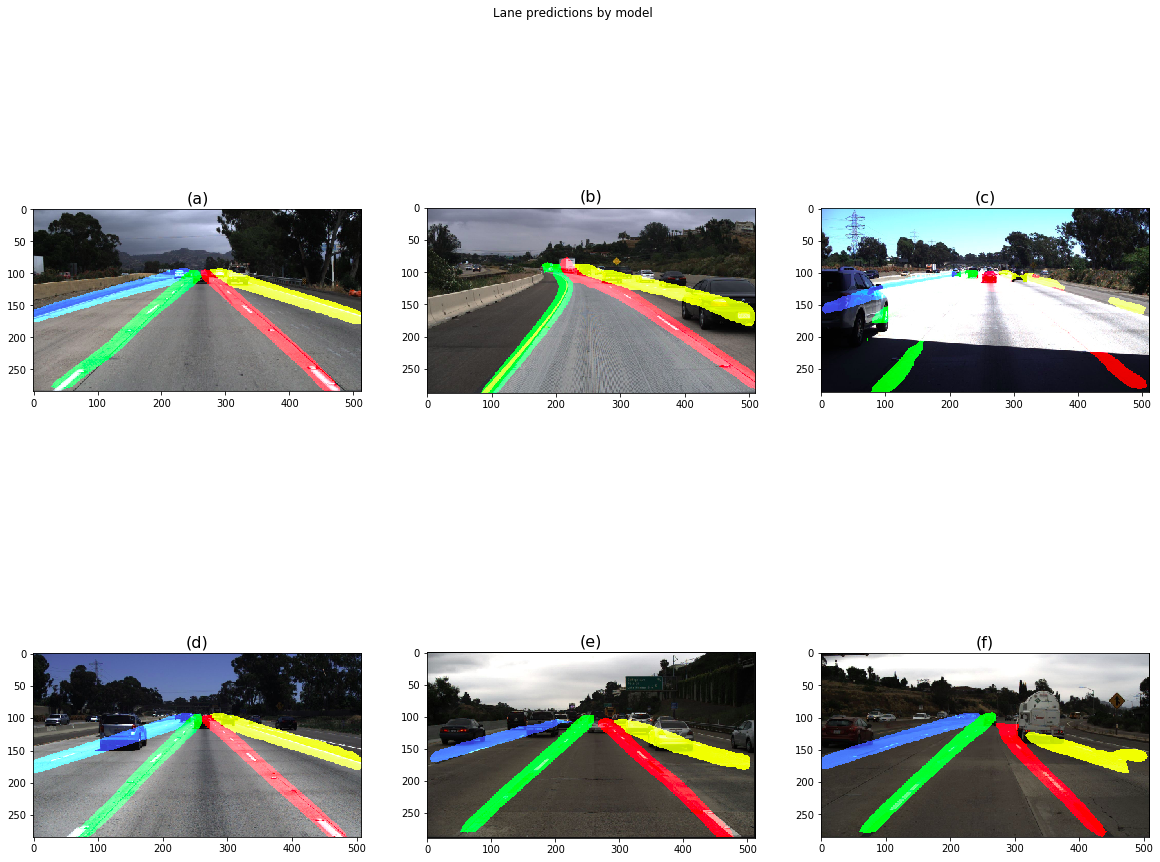

In [31]:
img1 = plt.imread('./../../images/1.png')
img2 = plt.imread('./../../images/2.png')
img3 = plt.imread('./../../images/3.png')
img4 = plt.imread('./../../images/4.png')
img5 = plt.imread('./../../images/5.png')
img6 = plt.imread('./../../images/6.png')

plt.imshow(img1)
# Plotting accuracies
fig, ax = plt.subplots(2, 3)
fig.suptitle('Lane predictions by model')
# Training

ax[0][0].imshow(img1)
ax[0][0].set_title('(a)', fontsize=16);
ax[0][1].imshow(img2)
ax[0][1].set_title('(b)', fontsize=16);
ax[0][2].imshow(img3)
ax[0][2].set_title('(c)', fontsize=16);
ax[1][0].imshow(img4)
ax[1][0].set_title('(d)', fontsize=16);
ax[1][1].imshow(img5)
ax[1][1].set_title('(e)', fontsize=16);
ax[1][2].imshow(img6)
ax[1][2].set_title('(f)', fontsize=16);